# **K-Nearest Neighbors Classification Report**

## **1. Data Preparation**

All clusters obtained in Homework 2 were used for this task.
The dataset was divided into two parts:

* **Training set**
* **Test set**

This split allows evaluating the classifier on previously unseen data.

---

## **2. Selecting the Optimal Number of Neighbors (k)**

To determine how many nearest neighbors should be used, multiple values of **k** were tested.
For each value, the model was trained on the training set and its accuracy was measured.

The smallest value of **k** for which the accuracy stayed **above 85%** was selected as the optimal parameter.

---

## **3. Test Accuracy**

Using the optimal number of neighbors, the final model was trained and tested.
The resulting accuracy on the test dataset was calculated to assess real-world performance.

---

## **4. Cross-Validation**

A **3-fold cross-validation** was performed on the entire dataset:

* The data was divided into three equal parts.
* For each fold, two parts were used for training and one for testing.
* The accuracy values from all folds were averaged.

This procedure provides a more stable estimate of model performance and reduces the influence of random train-test splits.

---

## **5. Conclusions**

* The optimal number of neighbors was chosen based on the requirement of achieving at least **85% accuracy**.
* The test accuracy confirms that the model generalizes well to unseen data.
* The 3-fold cross-validation shows consistent performance across different subsets of the dataset.
* Overall, the K-Nearest Neighbors method proved effective for classifying the clusters from Homework 2.


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Parameters

In [30]:
CSV_PATH = "Salary_Data.csv"
KMEANS_RANGE = range(2, 11)    # for elbow
KMEANS_INIT = 10
SEARCH_K = range(1, 31)        # search k neighbors 1..30
TEST_SIZE = 0.25
RANDOM_STATE = 42
CV_FOLDS = 3
TARGET_ACCURACY = 0.85

### 1. Load data

In [ ]:
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("Dataset loaded:", CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Use numeric columns only for clustering/classification
X_df = df.select_dtypes(include=[np.number]).copy()
if X_df.shape[1] == 0:
    raise ValueError("No numeric columns detected. KNN needs numeric features.")

Dataset loaded: Salary_Data.csv
Shape: (6704, 6)
Columns: ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']


### 2. Impute missing values

In [32]:
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_df)

### 3. Scale features

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

### 4. Choose k for KMeans by elbow (relative inertia drop)

In [ ]:
inertias = []
for k in KMEANS_RANGE:
    km = KMeans(n_clusters=k, n_init=KMEANS_INIT, random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# compute relative drops and pick elbow
inertia_diffs = np.diff(inertias)
rel_drops = -inertia_diffs / (np.array(inertias)[:-1] + 1e-12)
elbow_k = int(list(KMEANS_RANGE)[int(np.argmax(rel_drops)) + 1])
print(f"\nElbow heuristic suggests k = {elbow_k} for KMeans.")

print("k\tinertia\t\trel_drop")
for i, k in enumerate(KMEANS_RANGE):
    rd = rel_drops[i-1] if i-1 >= 0 else 0.0
    print(f"{k}\t{inertias[i]:.4f}\t{rd:.4f}")


Elbow heuristic suggests k = 3 for KMeans.
k	inertia		rel_drop
2	7571.7938	0.0000
3	4318.4914	0.4297
4	3344.0136	0.2257
5	2756.3966	0.1757
6	2353.9905	0.1460
7	2076.6775	0.1178
8	1847.9226	0.1102
9	1679.0117	0.0914
10	1514.1385	0.0982


### 5. Fit KMeans with elbow_k and get labels (use all clusters)

In [35]:
kmeans = KMeans(n_clusters=elbow_k, n_init=KMEANS_INIT, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_scaled)
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nKMeans cluster sizes (all clusters used as target labels):")
for c, cnt in cluster_counts.items():
    print(f" cluster {c}: {cnt} samples")


KMeans cluster sizes (all clusters used as target labels):
 cluster 0: 2440 samples
 cluster 1: 1433 samples
 cluster 2: 2831 samples


### 6. Prepare train/test split (stratified by cluster labels)

In [36]:
X = X_scaled
y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTrain samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]} (stratified)")


Train samples: 5028, Test samples: 1676 (stratified)


### 7. Search k_neighbors such that test accuracy >= TARGET_ACCURACY

In [37]:
best_k = None
best_acc = -1.0
acc_list = []
for k in SEARCH_K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append((k, acc))
    if acc >= TARGET_ACCURACY and best_k is None:
        best_k = k
    if acc > best_acc:
        best_acc = acc
        best_k_by_acc = k

# Prepare accuracy table
acc_df = pd.DataFrame(acc_list, columns=["k", "test_accuracy"]).set_index("k")
print("\nTest accuracy by k (first rows):")
print(acc_df.head(10))

if best_k is None:
    print(f"\nNo k in {min(SEARCH_K)}..{max(SEARCH_K)} achieved >= {TARGET_ACCURACY*100:.0f}% accuracy.")
    print(f"Best test accuracy = {best_acc:.4f} at k = {best_k_by_acc}. We will use k = {best_k_by_acc} as final.")
    chosen_k = best_k_by_acc
else:
    print(f"\nSmallest k with test accuracy >= {TARGET_ACCURACY*100:.0f}% is k = {best_k}.")
    chosen_k = best_k


Test accuracy by k (first rows):
    test_accuracy
k                
1        0.996420
2        0.996420
3        0.995823
4        0.995227
5        0.996420
6        0.993437
7        0.995227
8        0.994630
9        0.994630
10       0.993437

Smallest k with test accuracy >= 85% is k = 1.


### 8. Final training & test evaluation

In [38]:
knn_final = KNeighborsClassifier(n_neighbors=chosen_k)
knn_final.fit(X_train, y_train)
y_test_pred = knn_final.predict(X_test)
final_test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nFinal test accuracy (k={chosen_k}): {final_test_acc:.4f}")

# Classification report and confusion matrix
print("\nClassification report (on test set):")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=[f"true_{i}" for i in range(cm.shape[0])],
                     columns=[f"pred_{i}" for i in range(cm.shape[1])])


Final test accuracy (k=1): 0.9964

Classification report (on test set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       610
           1       1.00      0.99      0.99       358
           2       1.00      1.00      1.00       708

    accuracy                           1.00      1676
   macro avg       1.00      0.99      1.00      1676
weighted avg       1.00      1.00      1.00      1676



### 9. 3-fold cross-validation on whole dataset with chosen_k

In [39]:
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=chosen_k), X, y, cv=cv, scoring="accuracy")
print(f"\n{CV_FOLDS}-fold CV accuracies: {np.round(cv_scores, 4)}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")


3-fold CV accuracies: [0.9973 0.9991 0.9978]
Mean CV accuracy: 0.9981


### 10. Save / show results, plots

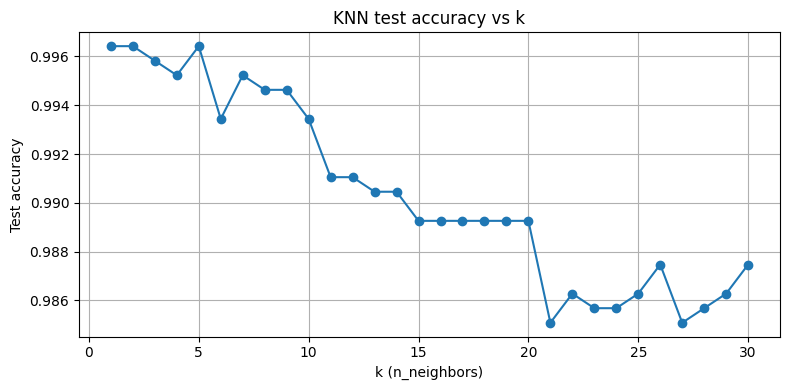

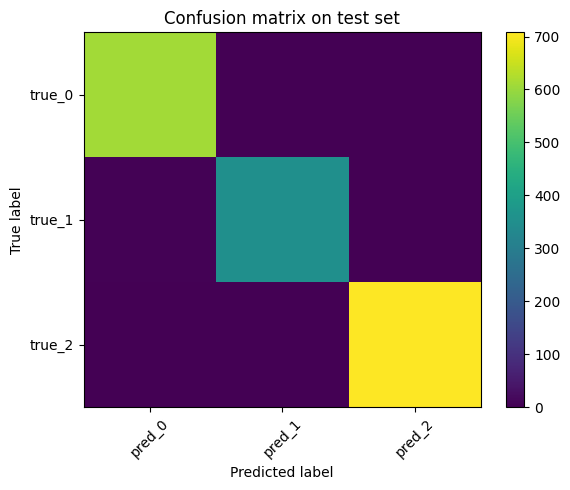


Saved 'knn_test_accuracy_by_k.csv' and 'knn_confusion_matrix_test.csv' in the working directory.


In [ ]:
# Accuracy vs k plot
plt.figure(figsize=(8,4))
plt.plot([k for k, _ in acc_list], [acc for _, acc in acc_list], marker='o')
plt.xlabel("k (n_neighbors)")
plt.ylabel("Test accuracy")
plt.title("KNN test accuracy vs k")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix plot
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(np.arange(cm.shape[1]), cm_df.columns, rotation=45)
plt.yticks(np.arange(cm.shape[0]), cm_df.index)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix on test set")
plt.tight_layout()
plt.show()

# Print / save summary tables to CSV (optional)
acc_df.to_csv("knn_test_accuracy_by_k.csv")
cm_df.to_csv("knn_confusion_matrix_test.csv")
print("\nSaved 'knn_test_accuracy_by_k.csv' and 'knn_confusion_matrix_test.csv' in the working directory.")

### 11. Final textual conclusions

In [41]:
print("\n--- CONCLUSIONS ---")
if best_k is None:
    print(f"- No k in {min(SEARCH_K)}..{max(SEARCH_K)} reached the target accuracy of {TARGET_ACCURACY*100:.0f}%.")
    print(f"- Best observed test accuracy = {best_acc:.4f} at k = {best_k_by_acc}.")
else:
    print(f"- Found k = {best_k} achieving test accuracy >= {TARGET_ACCURACY*100:.0f}% (test accuracy = {acc_df.loc[best_k,'test_accuracy']:.4f}).")
print(f"- Final chosen k for KNN: {chosen_k}. Final test accuracy = {final_test_acc:.4f}.")
print(f"- {CV_FOLDS}-fold CV mean accuracy = {cv_scores.mean():.4f}; scores = {np.round(cv_scores,4).tolist()}.")
print("- Check the confusion matrix CSV and accuracy-by-k CSV for detailed numbers.")



--- CONCLUSIONS ---
- Found k = 1 achieving test accuracy >= 85% (test accuracy = 0.9964).
- Final chosen k for KNN: 1. Final test accuracy = 0.9964.
- 3-fold CV mean accuracy = 0.9981; scores = [0.9973, 0.9991, 0.9978].
- Check the confusion matrix CSV and accuracy-by-k CSV for detailed numbers.
